Naive Bayes (NB) is a classification algorithm applicable both to binary and multiclass problems. Just like any Bayes-powered framework NB is based on the Bayes formula, namely: $P(C_k|X)\propto P(X|C_k)\times P(C_k)$

#### What does "naive" exactly mean in NB?
Naivety of the NB framework is related to assuming that every event is independent, therefore instead of multiplying all possible combinations of $P(x_i|x_{i+1},x_{i+2},...,x_n,C_k)$ for each $X$ we just assume that $p\left(x_i \mid x_{i+1}, \ldots, x_n, C_k\right)=p\left(x_i \mid C_k\right)$, therefore the overall $P(X|C_k)=\prod P(x_i|C_k)$ and the overall optimization problem is reduced to $\hat{y}=argmax_{k\in{1,...,K}}[p(C_k)\prod_{i=1}^Np(x_i|C_k)]$. Just like in Bayseian A/B testing , where we're challeging priors, here we could be dealing with different likelihoods, that are defined by the type of NB framework we're utilizing.

#### Types of NB classifiers
* Gaussian
> When dealing with continuos data we're usually assuming that values associated with each class are distributed according to a normal distribution, i.e. $p\left(x=v \mid C_k\right)=\frac{1}{\sqrt{2 \pi \sigma_k^2}} e^{-\frac{\left(v-\mu_k\right)^2}{2 \sigma_k^2}}$
* Multinomial
> We use this type of NB when dealing with $X$ representing frequencies of certain events, for example a simpliest TF-IDF embedding, where features ($x_i$) represent words and values for these features represent weighted frequencies corresponding to each word. In the Multinomial case we're finding the best $C_k$ based of $log P(C_k|X)=b+w_k^T$, where $b=log p(C_k)$ and $w_{ki}=log p_{ki}$

and others..

For the sake of simplicity we're only going to be covering the implementation of the Gaussian NB:

In [41]:
import numpy as np

class GaussNB():
    
    def __init__(self) -> None:
        self.X, self.y = None, None
        self.C = []
        self.params = []

    def _calc_likelihood(self, x, eps=1e-6, **kwargs):
        # note: epsilon is a small term to avoid zero division case
        mu, var = kwargs['mu'], kwargs['var']
        return (2*np.pi*var+eps)**(-.5) * \
            np.exp(-(x-mu)**2/(2*var+eps))
        
    def _calc_prior(self, C_k):
        return (self.y == C_k).mean()
    
    def _calc_posteriors(self, sample):
        posteriors = []
        for C_k in self.C:
            mu, var = self.params[C_k]['mu'], self.params[C_k]['var']
            posterior = self._calc_prior(C_k)
            for feature_value in sample:
                posterior *= self._calc_likelihood(
                    x=feature_value,
                    mu=mu,var=var)
            posteriors.append(posterior)
        return posteriors

    def fit_predict(self, X, y):
        self.X = X
        self.y = y
        self.C = np.unique(y)
        self.params = {C_k: {'mu': self.X[self.y==C_k].mean(),
                             'var': self.X[self.y==C_k].var()} for C_k in self.C}
        posteriors = [self._calc_posteriors(x_i) for x_i in self.X]
        
        return [self.C[np.argmax(posterior)] for posterior in posteriors]

Now we can compare our own implementation with scikit's learn GaussianNB on the example provided in the docs:

<Axes: xlabel='x1', ylabel='x2'>

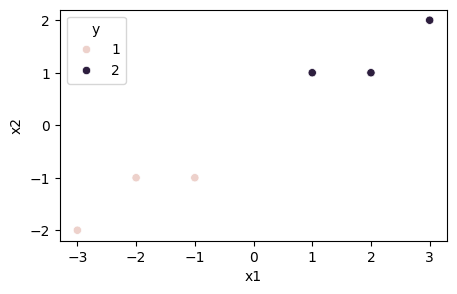

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

X = [[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]
Y = [1, 1, 1, 2, 2, 2]
trainDf = pd.DataFrame(list(zip(X,Y)), columns=['x','y'])
trainDf['x1'], trainDf['x2'] = trainDf['x'].str[0], trainDf['x'].str[1]
trainDf.drop(columns=['x'],inplace=True)
plt.rcParams["figure.figsize"] = (5,3)
sns.scatterplot(data=trainDf,x='x1',y='x2',hue='y')

In [42]:
# custom implementation
GaussNB().fit_predict(np.array(X),np.array(Y))

[1, 1, 1, 2, 2, 2]

In [40]:
# sklearn implementation
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X,Y)
clf.predict(X)

array([1, 1, 1, 2, 2, 2])